In [135]:
import os
import subprocess
import cv2
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from tqdm import tqdm

## Pixel difference

In [9]:
def similarity(frame1, frame2):
    #s = measure.compare_mse(frame1, frame2)
    s = measure.compare_ssim(frame1, frame2, multichannel=True)
    return s

In [26]:
def find_boundaries(vid_path):
    vidcap = cv2.VideoCapture(vid_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print(fps)
    vidcap.set
    success, frame1 = vidcap.read()
    sims = []
    count = 0
    while success:
        success, frame2 = vidcap.read()
        if success:
            sim = similarity(frame1, frame2)
            sims.append(sim)
            print("At frame {}: similarity = {}".format(count, sim))
            frame1 = frame2
            count += 1
    #Plotting time vs similarities
    plt.plot([x/fps for x in range(count)], sims)
    plt.show()
    return sims, fps

In [27]:
sims,_ = find_boundaries("../data/SAA_clip.mp4")

29.970000091532775
At frame 0: similarity = 0.9572475805796331


/home/eon/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


At frame 1: similarity = 0.961183102038721
At frame 2: similarity = 0.9630804807990967
At frame 3: similarity = 0.958740503328159
At frame 4: similarity = 0.9588116128568432
At frame 5: similarity = 0.9593227025028518
At frame 6: similarity = 0.962693165455569
At frame 7: similarity = 0.9541495577298468
At frame 8: similarity = 0.961377962560186
At frame 9: similarity = 0.9582877873251335
At frame 10: similarity = 0.9595284436854072
At frame 11: similarity = 0.9532174941149623
At frame 12: similarity = 0.9535443671722303
At frame 13: similarity = 0.9527970780570292
At frame 14: similarity = 0.9530637188663315
At frame 15: similarity = 0.9342848353294015
At frame 16: similarity = 0.9296721425366413
At frame 17: similarity = 0.9293778174413606
At frame 18: similarity = 0.9440657687098041
At frame 19: similarity = 0.9479596890286257
At frame 20: similarity = 0.9573514749018509


KeyboardInterrupt: 

In [30]:
sims_inv = [1-x for x in simsAny more inferences you get from this shit

Frame by frame - color information - match with previous - if different, mark boundary

Google - comparing images]

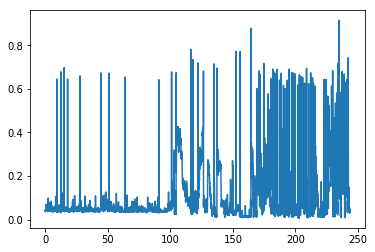

In [32]:
plt.plot([x/fps for x in range(len(sims))], sims_inv)

In [35]:
for i in range(len(sims_inv)):
    if(sims_inv[i]==max(sims_inv)):
        print(i/fps)

235.03503431720358


## PySceneDetect

In [92]:
def time_to_milsec(timestr):
    HMS,MSEC = timestr.split('.')
    x = time.strptime(HMS,'%H:%M:%S')
    seconds = datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    return seconds*1000 + int(MSEC)

In [106]:
def shot_boundaries(vid_path):
    command = "scenedetect -i {} -s video.stats.csv detect-content list-scenes".format(vid_path)
    os.system(command)
    file_name = os.path.basename(vid_path).split('.')[0]
    results = pd.read_csv("{}-Scenes.csv".format(file_name))
    results = results.columns.tolist()[1:] #List of timestamps of shot boundaries
    shot_bounds = [time_to_milsec(x) for x in results]
    return shot_bounds

In [147]:
def get_key_frames(shot_bounds, vid_path):
    # Taking centre frame of each shot - creating a list of such 
    # centre frames from the extracted shot boundaries
    key_frames = []
    timestamps = []
    bound1 = 0
    vidcap = cv2.VideoCapture(vid_path)
    for i in range(len(shot_bounds) + 1):
        
        if(i != len(shot_bounds)): #not last boundary
            bound2 = shot_bounds[i]
            
        else: #last boundary
            vidcap.set(cv2.CAP_PROP_POS_AVI_RATIO,1)
            bound2 = vidcap.get(cv2.CAP_PROP_POS_MSEC) #max duration
            
        key_frame_msec = (bound1 + bound2)/2 #Average of 2 boundaries
        timestamps.append(key_frame_msec)
        print(key_frame_msec)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,key_frame_msec)
        _,image = vidcap.read() #Reading frame at key_frame_sec
        key_frames.append(image) #storing frame as np array
        bound1 = bound2
        
    return key_frames,timestamps

In [143]:
def find_scenes(vid_path, threshold):
    print('Finding shot boundaries...')
    shot_bounds = shot_boundaries(vid_path)
    print('Extracting key frames...')
    key_frames, kf_timestamps = get_key_frames(shot_bounds,vid_path)
    #print(key_frames)
    scene_count = 0
    scenes = [0] #What scene is each shot - length = no. of shots [Maps shots to scenes]
    key_shots = [0] #Key shot* for each scene [Maps scenes to their key shots]
    print('Classifying shots into scenes...')
    for i in tqdm(range(1, len(key_frames))): #For each shot
        curr_shot = key_frames[i]
        for j,key_shot in enumerate(key_shots): #Iterate through each scene
            if(similarity(key_frames[key_shot],curr_shot) > threshold):
                scenes.append(j) #Mark the shot as belonging to this scene
                break
            elif(j==len(key_shots)-1): #End of scenes => No matching scene is found
                scene_count += 1 
                scenes.append(scene_count) #This shot belongs to the new scene
                key_shots.append(i) #Mark this shot as key shot of the new scene
    return scenes, key_shots, scene_count, key_frames, kf_timestamps    

In [145]:
a,b,c,d = find_scenes("../data/SAA_clip.mp4", 0.6)

Finding shot boundaries...
Extracting key frames...


  0%|          | 0/74 [00:00<?, ?it/s]/home/eon/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
  1%|▏         | 1/74 [00:00<00:14,  5.13it/s]

[array([[[ 4,  0,  1],
        [ 4,  0,  1],
        [ 4,  0,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 4,  0,  1],
        [ 4,  0,  1],
        [ 4,  0,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 4,  0,  1],
        [ 4,  0,  1],
        [ 4,  0,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[14,  0, 15],
        [14,  0, 15],
        [ 8,  0, 15],
        ...,
        [ 2,  0,  1],
        [ 2,  0,  1],
        [ 2,  0,  1]],

       [[ 2,  0,  1],
        [ 2,  0,  1],
        [ 2,  0,  1],
        ...,
        [ 2,  0,  3],
        [ 2,  0,  3],
        [ 2,  0,  3]],

       [[ 2,  0,  1],
        [ 2,  0,  1],
        [ 2,  0,  1],
        ...,
        [ 3,  0,  4],
        [ 3,  0,  4],
        [ 3,  0,  4]]], dtype=uint8), array([[[ 6,  0,  1],
        [ 7,  0,  2],
        [ 7,  0,  2],
        ...,
        [ 2

100%|██████████| 74/74 [03:45<00:00,  6.89s/it]


In [150]:
a

[0,
 1,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 20,
 20,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 25,
 25,
 26,
 26,
 27,
 27,
 28,
 28,
 29,
 29,
 30,
 30,
 31,
 31,
 32,
 32,
 33,
 33,
 34,
 34,
 35,
 35,
 36,
 36,
 37,
 37,
 38,
 38,
 39,
 39,
 40,
 40,
 41,
 41,
 42,
 42,
 43,
 43,
 44,
 44,
 45,
 45,
 46,
 46,
 47,
 47,
 4,
 48,
 48,
 49,
 49,
 50,
 50,
 51,
 51,
 52,
 52,
 53,
 53,
 54,
 54,
 55,
 55,
 56,
 56,
 57,
 57,
 58,
 58,
 59,
 59,
 60,
 60,
 61,
 61,
 62,
 62,
 63,
 63,
 64,
 64,
 65,
 65,
 66,
 66]